# FAST-UAV - Uncertainty analysis

The purpose of this notebook is to run uncertainty analyses in order to evaluate the impacts of models uncertainty and input parameters uncertainty.

## 1. Setting up the deterministic problem

In a first place, we define in the configuration file the UAV models that will be used to run the analyses. Here, no optimization of the design is carried out, i.e. we start from an existing design and analyse its performance on a given mission.

In [1]:
import os.path as pth
import openmdao.api as om
import logging
import shutil
import fastoad.api as oad
from time import time
from fastuav.utils.drivers.cmaes_driver import CMAESDriver
import cma
import matplotlib.pyplot as plt
from fastuav.utils.postprocessing.sensitivity_analysis.sensitivity_analysis import (
    morris_analysis,
    sobol_analysis,
)

plt.rcParams["figure.figsize"] = 16, 8
plt.rcParams.update({"font.size": 13})

DATA_FOLDER_PATH = "../data"
CONFIGURATIONS_FOLDER_PATH = "../configurations"
WORK_FOLDER_PATH = "./workdir"

CONFIGURATION_FILE_MDA = pth.join(WORK_FOLDER_PATH, "multirotor_mda.yaml")  # MDA Problem (i.e., with consistency constraints solving)
SOURCE_FILE = pth.join(DATA_FOLDER_PATH, "problem_outputs_DJI_M600_mdo.xml")

# For having log messages display on screen
# logging.basicConfig(level=logging.INFO, format='%(levelname)-8s: %(message)s')

# For using all screen width
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

C:\Users\f.pollet.ISAE-SUPAERO\AppData\Local\Temp\ipykernel_2964\2488757765.py:29: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Let's start by defining the multidisciplinary analysis (MDA). The [MDA](https://websites.isae-supaero.fr/IMG/pdf/2016_mca_martins_mdo_course_slides.pdf) consists of evaluating the model while solving the coupled equations.<br>
With a NVH formulation as adopted in FAST-UAV, the MDA is carried out by the optimizer instead of a dedicated solver. The optimizer is responsible for solving the consistency constraints, that is the coupled states of the system. For more information about the consistency constraints please refer to Delbecq et al. article available [here](https://oatao.univ-toulouse.fr/26691/).

In [2]:
oad.generate_configuration_file(
    CONFIGURATION_FILE_MDA, overwrite=True, distribution_name="fastuav", sample_file_name="multirotor_mda.yaml"
)

'D:\\THESE\\Tools\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\multirotor_mda.yaml'

In [3]:
N2_FILE = pth.join(WORK_FOLDER_PATH, "n2.html")
oad.write_n2(CONFIGURATION_FILE_MDA, N2_FILE, overwrite=True)
from IPython.display import IFrame
IFrame(src=N2_FILE, width="100%", height="500px")

We now load an existing UAV design on which the uncertainty analysis will be run.

In [4]:
oad.variable_viewer(SOURCE_FILE)

To make sure that the source file is consistent with the problem definition and the models, an MDA is carried out. No difference between the values of the source file and the output values of the problem should be observed.<br>

In [6]:
INPUT_FILE = oad.generate_inputs(CONFIGURATION_FILE_MDA, SOURCE_FILE, overwrite=True)
problem = oad.optimize_problem(
    CONFIGURATION_FILE_MDA, overwrite=True
)  # Run MDA
REFERENCE_DESIGN_FILE = pth.join(WORK_FOLDER_PATH, "problem_outputs.xml")
oad.variable_viewer(REFERENCE_DESIGN_FILE)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.5422226689822316
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
Optimization Complete
-----------------------------------


## 2. Design of Experiments

In contrast with a single problem evaluation, the uncertainty analysis relies on multiple evaluations of the problem to analyse the effects of varying one or several parameters on the output variables of interest.

The [OpenTurns](https://openturns.github.io/openturns/latest/index.html) and [SALib](https://salib.readthedocs.io/en/latest/index.html) libraries are used to set up the DoEs and run the sensitivity analyses. 
The drivers to connect these librairies to FAST-UAV are provided by Onera's [OpenMDAO Extensions](https://github.com/OneraHub/openmdao_extensions).

## 2.1 Screening procedure - Morris method

The Morris method allows to get a measure of importance and interaction of input factors. It is used as a screening method to reduce the number of parameters prior to a more detailed analysis.

The `morris_analysis` function takes the following inputs:
- The configuration file of the problem to be evaluated;
- The source file containing the reference design, to help the user to set up the analysis (uncertain parameters selection, output variable of interest, ...). 

The number of simulation runs required are $r(k+1)$ where $r$ is the number of trajectories (typically between 4 to 10) and $k$ the number of parameters.

**Bibliography**

> Ruano, M.V., Ribes, J., Seco, A., Ferrer, J., 2012. An improved sampling strategy based on trajectory design for application of the Morris method to systems with many input factors. Environmental Modelling & Software 37, 103–109. https://doi.org/10.1016/j.envsoft.2012.03.008

> Morris, M.D., 1991. Factorial Sampling Plans for Preliminary Computational Experiments. Technometrics 33, 161–174. https://doi.org/10.1080/00401706.1991.10484804

> Campolongo, F., Cariboni, J., Saltelli, A., 2007. An effective screening design for sensitivity analysis of large models. Environmental Modelling & Software, Modelling, computer-assisted simulations, and mapping of dangerous phenomena for hazard assessment 22, 1509–1518. https://doi.org/10.1016/j.envsoft.2006.10.004


In [8]:
morris_analysis(CONFIGURATION_FILE_MDA, REFERENCE_DESIGN_FILE)

    'data': [{'error_y': {'array': [], 'type': 'data'},
         …

## 2.2 Global sensitivity analysis - Sobol' indices using Saltelli's sampling scheme

The Sobol' method allows to get a representation of the contribution of the inputs to the overall uncertainty in the model output. The space of the uncertain inputs is explored with a Monte Carlo sampling (here Saltelli's scheme, which extends the Sobol' sequence in a way to reduce the error rates in the resulting sensitivity index calculations).

The number of simulation runs required are $m(k+2)$ where $m$ is the number of samples (typically between 100s to 1000s) and $k$ the number of parameters.

**Bibliography**

> Campolongo, F., Saltelli, A., Cariboni, J., 2011. From screening to quantitative sensitivity analysis. A unified approach. Computer Physics Communications 182, 978–988. https://doi.org/10.1016/j.cpc.2010.12.039

> Saltelli, A., 2002. Making best use of model evaluations to compute sensitivity indices. Computer Physics Communications 145, 280–297. https://doi.org/10.1016/S0010-4655(02)00280-1

> Sobol’, I.M., 2001. Global sensitivity indices for nonlinear mathematical models and their Monte Carlo estimates. Mathematics and Computers in Simulation, The Second IMACS Seminar on Monte Carlo Methods 55, 271–280. https://doi.org/10.1016/S0378-4754(00)00270-6


In [9]:
sobol_analysis(CONFIGURATION_FILE_MDA, REFERENCE_DESIGN_FILE)

    'data': [{'error_y': {'array': [], 'type': 'data'},
         …

## 2.3 -  Dev/Expert mode
You may reuse data from the DoEs ran with `morris_analysis` and `sobol_analysis` methods to display custom plots or run new analyses.

In [8]:
import pandas as pd
# import seaborn as sns
from fastuav.utils.postprocessing.sensitivity_analysis.sobol_plot import sobol_plot
from fastuav.utils.postprocessing.sensitivity_analysis.morris_plot import morris_plot
from SALib.analyze import sobol, morris

plt.rcParams.update({"font.size": 15, "lines.markersize": 10, "figure.figsize": [12, 6]})
SA_PATH = "./workdir/sensitivity_analysis"

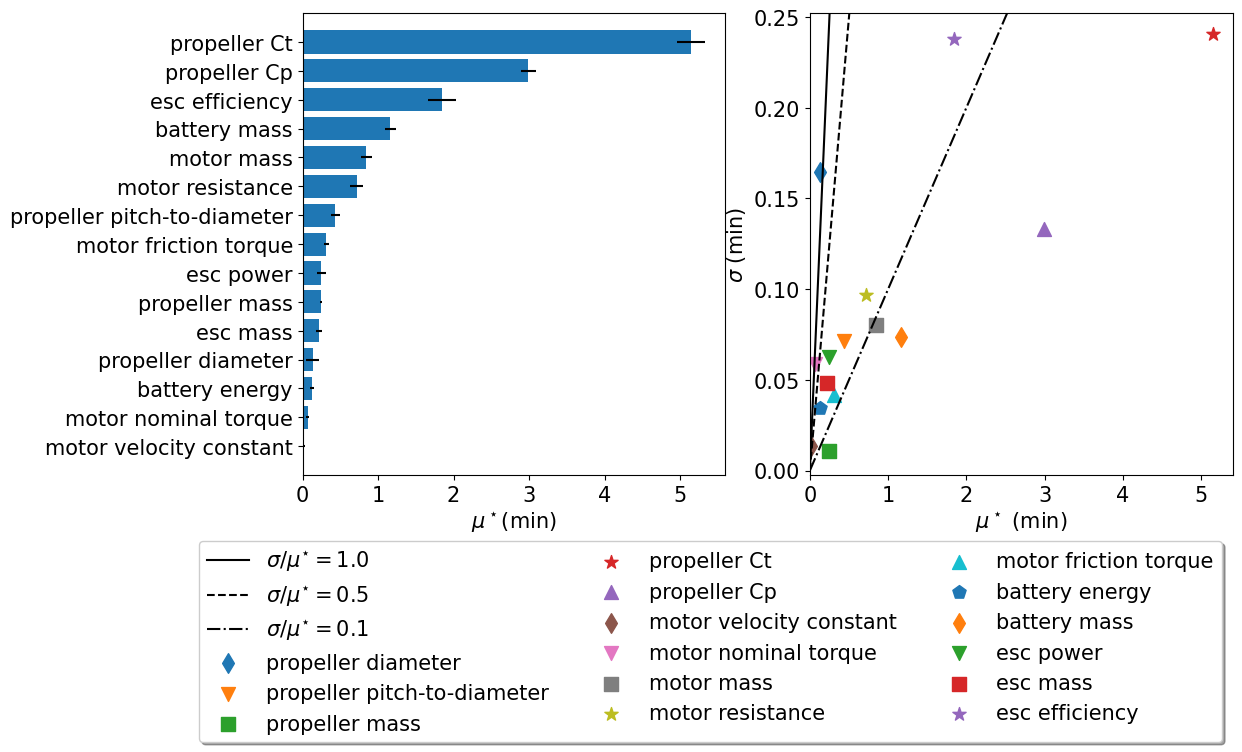

In [9]:
# MORRIS METHOD

# Load DoE csv file
df_morris = pd.read_csv(SA_PATH + "/doe_Morris.csv", sep=",")

# Load problem and output definitions
f_problem = open(SA_PATH + "/problem_morris.txt", "r")  # if you want to customize the variables' names, modify them in the problem_morris.txt file directly.
f_inputs = open(SA_PATH + "/x_morris.txt", "r")
f_output = open(SA_PATH + "/y_morris.txt", "r")
# print(f_problem.read())
problem = eval(f_problem.read())
x = eval(f_inputs.read())
y = f_output.read()
f_problem.close()
f_inputs.close()
f_output.close()

# Read data
X = df_morris[x].to_numpy()
Y = df_morris[y].to_numpy()

# Run Morris analysis with SALib
Si = morris.analyze(problem, X, Y, print_to_console=False, conf_level=0.95, num_resamples=100)

# Plot results
fig = morris_plot(Si, unit="(min)")
plt.savefig(SA_PATH + "/figures/morris_plot.pdf", bbox_inches="tight", dpi=1200)

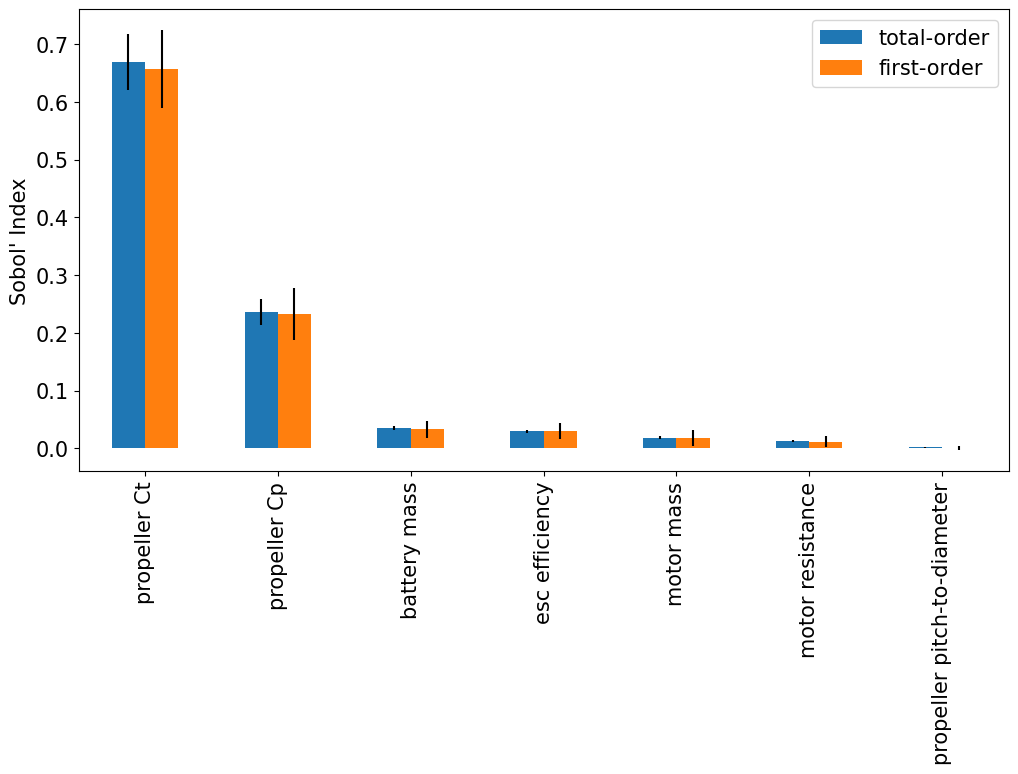

In [10]:
# SOBOL' METHOD

# Load DoE csv file
df_sobol = pd.read_csv(SA_PATH + "/doe_Sobol.csv", sep=",")

# Load problem and output definitions
f_problem = open(SA_PATH + "/problem_sobol.txt", "r")
f_output = open(SA_PATH + "/y_sobol.txt", "r")
problem = eval(f_problem.read())
y = f_output.read()
f_problem.close()
f_output.close()

# Read data
Y = df_sobol[y].to_numpy()

# Run Sobol analysis with SALib
Si = sobol.analyze(problem, Y, calc_second_order=True)

# Plot results
fig = sobol_plot(Si)
plt.savefig(SA_PATH + "/figures/sobol_plot.pdf", bbox_inches="tight")

mu =  18.076413403665526
std =  3.2313305772219967


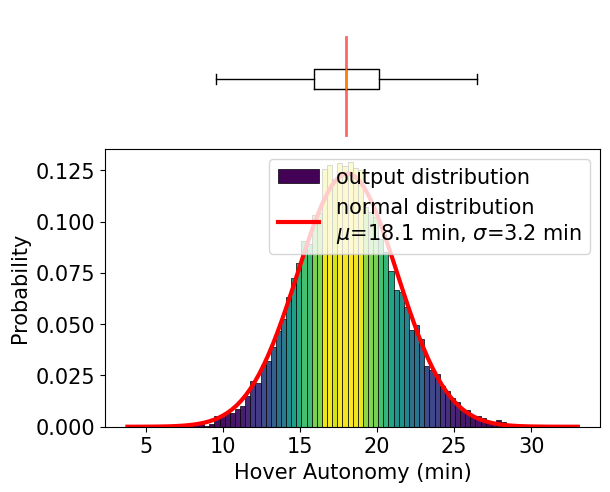

In [11]:
# OUTPUT DISTRIBUTION
from scipy.stats import norm
import numpy as np
from matplotlib import colors

def output_dist_plot(df_output, y):
    # Get data and fit normal law
    df_output = pd.read_csv(SA_PATH + "/doe_Sobol.csv", sep=",")
    mu, std = norm.fit(df_output[y])
    print("mu = ", mu)
    print("std = ", std)

    # Initialize plot
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6,5), gridspec_kw={'height_ratios': [1, 2]})
    fig.tight_layout()

    # Plot the histogram.
    q25, q50, q75 = np.percentile(df_output[y], [25, 50, 75])
    bin_width = 2 * (q75 - q25) * len(df_output[y]) ** (-1 / 3)  # Freedman–Diaconis number of bins
    bins = round((df_output[y].max() - df_output[y].min()) / bin_width)
    n, bins, patches = axes[1].hist(
        df_output[y],
        bins=bins,
        density=True,
        edgecolor='black', 
        linewidth=0.5,
        label="output distribution",
    )
    fracs = n / n.max()
    norm_color = colors.Normalize(fracs.min(), fracs.max())
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm_color(thisfrac))
        thispatch.set_facecolor(color)

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    axes[1].plot(x, p, "r", linewidth=3, label="normal distribution" "\n" "$\mu$=18.1 min, $\sigma$=3.2 min")

    plt.xlabel("Hover Autonomy (min)")
    plt.ylabel("Probability")
    axes[1].legend()

    #top boxplot
    axes[0].boxplot(df_output[y], 0, "", vert=False)
    axes[0].axvline(q50, ymin=0.1, ymax=0.8, color='red', alpha=.6, linewidth=2)
    axes[0].axis('off')
    plt.subplots_adjust(hspace=0)
    
    return fig

df_output = pd.read_csv(SA_PATH + "/doe_Sobol.csv", sep=",")
fig = output_dist_plot(df_output, y);
plt.savefig(SA_PATH + "/figures/output_dist.pdf", bbox_inches="tight")

mu =  18.076413403665526
std =  3.2313305772219967


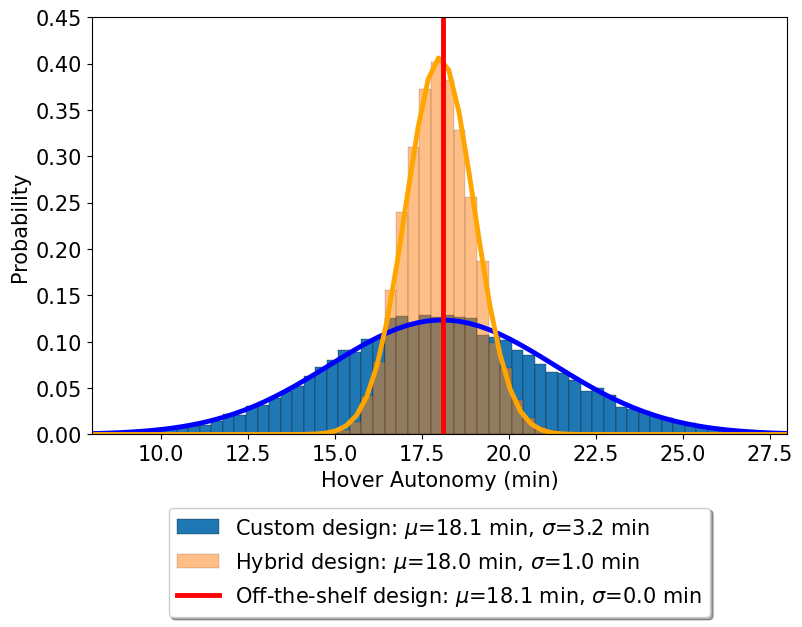

In [12]:
# OUTPUT DISTRIBUTION
from scipy.stats import norm
import numpy as np
from matplotlib import colors

def output_dist_plot(df_output, df_output_2, y):
    # Get data and fit normal law
    df_output = pd.read_csv(SA_PATH + "/doe_Sobol.csv", sep=",")
    mu, std = norm.fit(df_output[y])
    print("mu = ", mu)
    print("std = ", std)

    # Initialize plot
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,5)) #, sharex=True, gridspec_kw={'height_ratios': [1, 2]})
    fig.tight_layout()

    # Plot the histogram.
    q25, q50, q75 = np.percentile(df_output[y], [25, 50, 75])
    bin_width = 2 * (q75 - q25) * len(df_output[y]) ** (-1 / 3)  # Freedman–Diaconis number of bins
    bins = round((df_output[y].max() - df_output[y].min()) / bin_width)
    _, bins, _ = axes.hist(
        df_output[y],
        bins=bins,
        density=True,
        edgecolor='black', 
        linewidth=0.2,
        label=r"Custom design: $\mu$=18.1 min, $\sigma$=3.2 min",
    )
    _ =  axes.hist(df_output_2[y], bins=bins, density=True, edgecolor='black', linewidth=0.2, alpha=0.5, label="Hybrid design: $\mu$=18.0 min, $\sigma$=1.0 min")
    
    # fracs = n / n.max()
    #norm_color = colors.Normalize(fracs.min(), fracs.max())
    #for thisfrac, thispatch in zip(fracs, patches):
    #    color = plt.cm.viridis(norm_color(thisfrac))
    #    thispatch.set_facecolor(color)

    # Plot the PDFs.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    mu, std = norm.fit(df_output[y])
    p = norm.pdf(x, mu, std)
    axes.plot(x, p, "b", linewidth=3.5)
    
    mu, std = norm.fit(df_output_2[y])
    p = norm.pdf(x, mu, std)
    axes.plot(x, p, "orange", linewidth=3.5)
    
    # off-the-shelf dist
    _ = axes.axvline(x = 18.1, color = 'r', label = 'Off-the-shelf design: $\mu$=18.1 min, $\sigma$=0.0 min', linewidth=3.5)

    # plot parameters
    plt.xlabel("Hover Autonomy (min)")
    plt.ylabel("Probability")
    plt.xlim([8, 28])
    plt.ylim([0.0, 0.45])
    axes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=1, fancybox=True, shadow=True)

    
    
    #top boxplot
    #axes[0].boxplot(df_output[y], 0, "", vert=False)
    #axes[0].axvline(q50, ymin=0.1, ymax=0.8, color='red', alpha=.6, linewidth=2)
    #axes[0].axis('off')
    #plt.subplots_adjust(hspace=0)
    
    return fig

df_output = pd.read_csv(SA_PATH + "/doe_Sobol.csv", sep=",")
df_output_2 = pd.read_csv(SA_PATH + "/doe_Sobol_2.csv", sep=",")
fig = output_dist_plot(df_output, df_output_2, y);
plt.savefig(SA_PATH + "/figures/output_dist_combined.pdf", bbox_inches="tight")

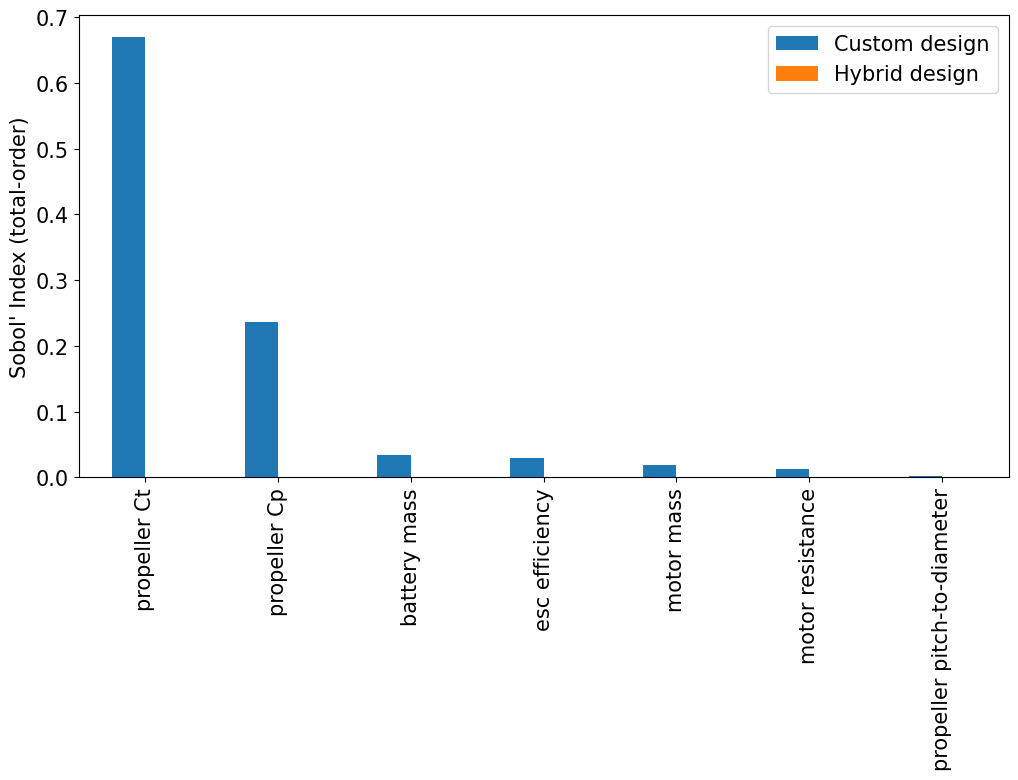

In [13]:
# SOBOL' COMPARISON

# SOBOL' 1
# Load DoE csv file
df_sobol = pd.read_csv(SA_PATH + "/doe_Sobol.csv", sep=",")
# Load problem and output definitions
f_problem = open(SA_PATH + "/problem_sobol.txt", "r")
f_output = open(SA_PATH + "/y_sobol.txt", "r")
problem = eval(f_problem.read())
y = f_output.read()
f_problem.close()
f_output.close()
# Read data
Y = df_sobol[y].to_numpy()
# Run Sobol analysis with SALib
Si_1 = sobol.analyze(problem, Y, calc_second_order=True)

# SOBOL' 2
# Load DoE csv file
df_sobol = pd.read_csv(SA_PATH + "/doe_Sobol_2.csv", sep=",")
# Load problem and output definitions
f_problem = open(SA_PATH + "/problem_sobol_2.txt", "r")
f_output = open(SA_PATH + "/y_sobol_2.txt", "r")
problem = eval(f_problem.read())
y = f_output.read()
f_problem.close()
f_output.close()
# Read data
Y = df_sobol[y].to_numpy()
# Run Sobol analysis with SALib
Si_2 = sobol.analyze(problem, Y, calc_second_order=True)

# PLOT
CONF_COLUMN = "_conf"
total_1, first_1, _ = Si_1.to_df()
total_1 = total_1.rename(columns={"ST": "Custom design"})
total_2, first_2, _ = Si_2.to_df()
total_2["ST"] = 0
total_2 = total_2.rename(columns={"ST": "Hybrid design"})
Si_df = pd.concat([total_1, total_2], axis=1)
conf_cols = Si_df.columns.str.contains(CONF_COLUMN)
Sis = Si_df.loc[:, ~conf_cols]
ax = Sis.plot(kind="bar", ax=None, stacked=False, ylabel="Sobol' Index (total-order)")